In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

## Parameters

In [2]:
dicLagged={"_X12":12,
           "_X24":24,
           "_Y12":-12,
           "_Y24":-24}


## Loading data

In [3]:
train=pd.read_csv('data/TrainData4.csv')
input_data=pd.read_csv('data/WeatherForecastInput4.csv')
train.head()

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 00:00,NaN,NaN,NaN,NaN,NaN
1,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
2,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768
3,20150101 03:00,0.666693,5.99531,4.89334,9.52143,6.99094
4,20150101 04:00,NaN,6.90809,4.79099,10.63280,6.75417


In [4]:
train.describe()

,POWER,U10,V10,U100,V100
count,27261.000000,27720.000000,27720.000000,27720.000000,27720.000000
mean,0.517775,2.211316,0.721899,3.028746,1.079522
std,0.313800,5.125725,4.502973,7.042252,6.172539
min,0.000000,-11.649200,-18.724500,-15.922300,-25.071400
25%,0.227213,-1.885478,-2.539125,-2.400520,-3.432050
50%,0.538978,2.690965,0.761054,3.794965,1.049430
75%,0.810858,6.005790,3.838205,8.187487,5.350662
max,1.000000,21.876300,18.122800,31.050900,25.117400


## Preprocessing

In [5]:
train['TIMESTAMP']=pd.to_datetime(train['TIMESTAMP'],format="%Y%m%d %H:%M")

In [6]:
train['WS10']=[sqrt(train['U10'][i]**2+train['V10'][i]**2) for i in range(len(train['U10']))]
train['WS100']=[sqrt(train['U100'][i]**2+train['V100'][i]**2) for i in range(len(train['U100']))]
train['WS']=[np.interp(70, [10,100], [train['WS10'][i],train['WS100'][i]]) for i in range(len(train['WS10']))]

In [7]:
train=train.set_index("TIMESTAMP")

### Inputing with interpolation

In [8]:
train['FillInterp']=train['POWER'].interpolate(method="time")

In [9]:
train = train.assign(MISSING= np.nan)
train.MISSING[train.POWER.isna()] = train.FillInterp

In [10]:
train.head()

,POWER,U10,V10,U100,V100,WS10,WS100,WS,FillInterp,MISSING
TIMESTAMP,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,NaN,6.24102,3.49613,9.73707,4.78492,7.153548,10.849239,9.617342,NaN,NaN
2015-01-01 02:00:00,NaN,5.62234,4.06239,8.94497,5.71768,6.936405,10.616231,9.389622,NaN,NaN
2015-01-01 03:00:00,0.666693,5.99531,4.89334,9.52143,6.99094,7.738767,11.812319,10.454468,0.666693,NaN
2015-01-01 04:00:00,NaN,6.90809,4.79099,10.63280,6.75417,8.406860,12.596636,11.200044,0.756962,0.756962


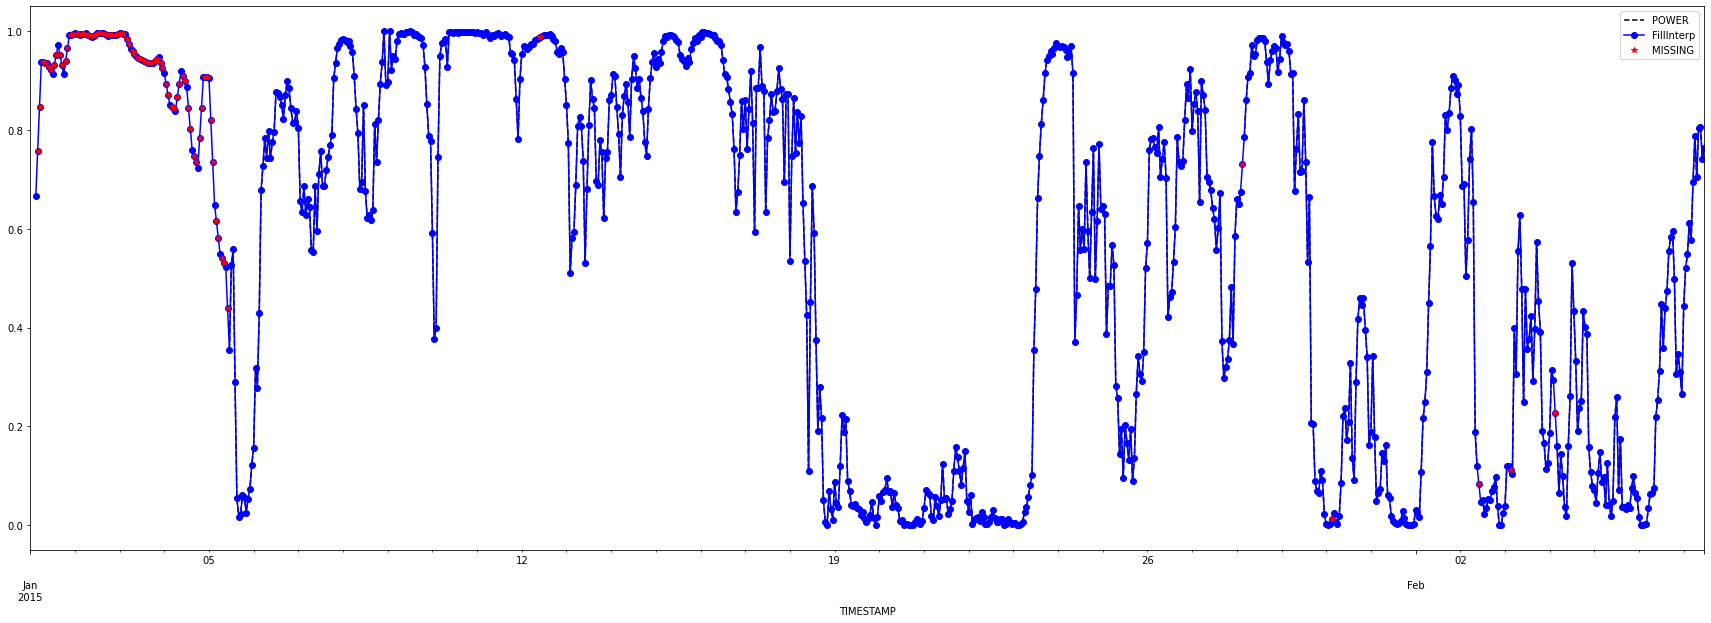

In [11]:
train[['POWER','FillInterp','MISSING']].head(900).plot(style=['k--', 'bo-', 'r*'], figsize=(30, 10))
plt.show()

### Inputing with mean/median

In [12]:
#Use assign to avoid pandas warning
train = train.assign(FillMean=train.POWER.fillna(train.POWER.mean()))
train = train.assign(FillMedian=train.POWER.fillna(train.POWER.median()))

In [13]:
train.head()

,POWER,U10,V10,U100,V100,WS10,WS100,WS,FillInterp,MISSING,FillMean,FillMedian
TIMESTAMP,,,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517775,0.538978
2015-01-01 01:00:00,NaN,6.24102,3.49613,9.73707,4.78492,7.153548,10.849239,9.617342,NaN,NaN,0.517775,0.538978
2015-01-01 02:00:00,NaN,5.62234,4.06239,8.94497,5.71768,6.936405,10.616231,9.389622,NaN,NaN,0.517775,0.538978
2015-01-01 03:00:00,0.666693,5.99531,4.89334,9.52143,6.99094,7.738767,11.812319,10.454468,0.666693,NaN,0.666693,0.666693
2015-01-01 04:00:00,NaN,6.90809,4.79099,10.63280,6.75417,8.406860,12.596636,11.200044,0.756962,0.756962,0.517775,0.538978


### Inputing with rolling mean/median

In [14]:
train = train.assign(FillRollingMean=train.POWER.fillna(train.POWER.rolling(24,min_periods=1).mean()))
train = train.assign(FillRollingMedian=train.POWER.fillna(train.POWER.rolling(24,min_periods=1).median()))

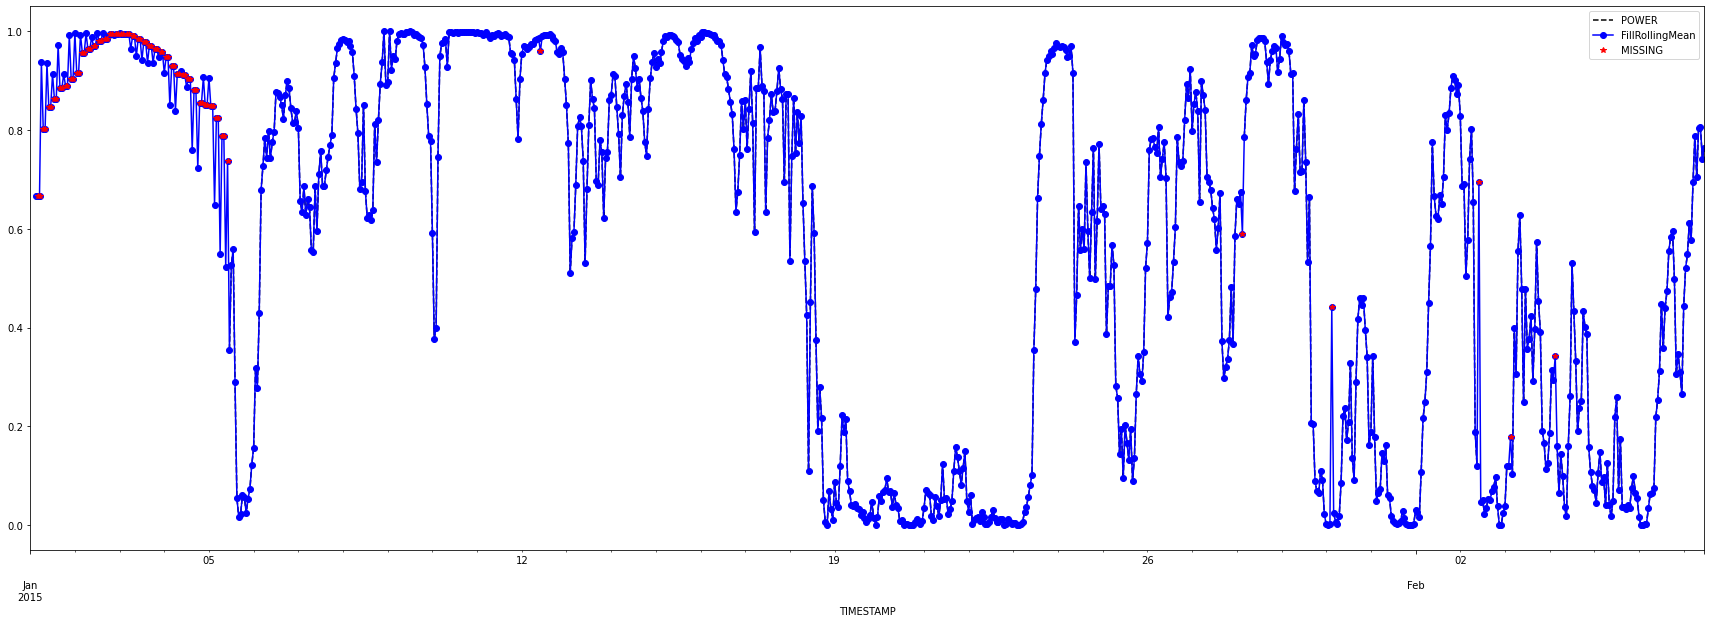

In [15]:
train = train.assign(MISSING= np.nan)
train.MISSING[train.POWER.isna()] = train.FillRollingMean
train[['POWER','FillRollingMean','MISSING']].head(900).plot(style=['k--', 'bo-', 'r*'], figsize=(30, 10))
plt.show()

### Seasonality

In [16]:
target_column="FillInterp"
df=train.dropna(subset=[target_column])

In [17]:
df.describe()

,POWER,U10,V10,U100,V100,WS10,WS100,WS,FillInterp,MISSING,FillMean,FillMedian,FillRollingMean,FillRollingMedian
count,27261.000000,27718.000000,27718.000000,27718.000000,27718.000000,27718.000000,27718.000000,27718.000000,27718.000000,309.000000,27718.000000,27718.000000,27570.000000,27570.000000
mean,0.517775,2.211047,0.721679,3.028290,1.079221,6.560904,9.013407,8.195906,0.516589,0.596900,0.517775,0.518124,0.518661,0.518849
std,0.313800,5.125812,4.503060,7.042302,6.172658,2.985671,4.097183,3.710848,0.313979,0.273781,0.311203,0.311214,0.313487,0.313709
min,0.000000,-11.649200,-18.724500,-15.922300,-25.071400,0.025588,0.036808,0.076573,0.000000,0.033619,0.000000,0.000000,0.000000,0.000000
25%,0.227213,-1.885653,-2.539155,-2.401460,-3.432170,4.363656,6.080668,5.507048,0.224933,0.440919,0.233023,0.233023,0.228445,0.228299
50%,0.538978,2.690410,0.760934,3.794790,1.048895,6.313614,8.686391,7.894436,0.536184,0.640315,0.528928,0.538978,0.539951,0.540495
75%,0.810858,6.005650,3.837892,8.186798,5.349997,8.466902,11.543553,10.517396,0.810184,0.832781,0.806983,0.806983,0.810987,0.811347
max,1.000000,21.876300,18.122800,31.050900,25.117400,22.269912,31.450741,28.377922,1.000000,0.993474,1.000000,1.000000,1.000000,1.000000


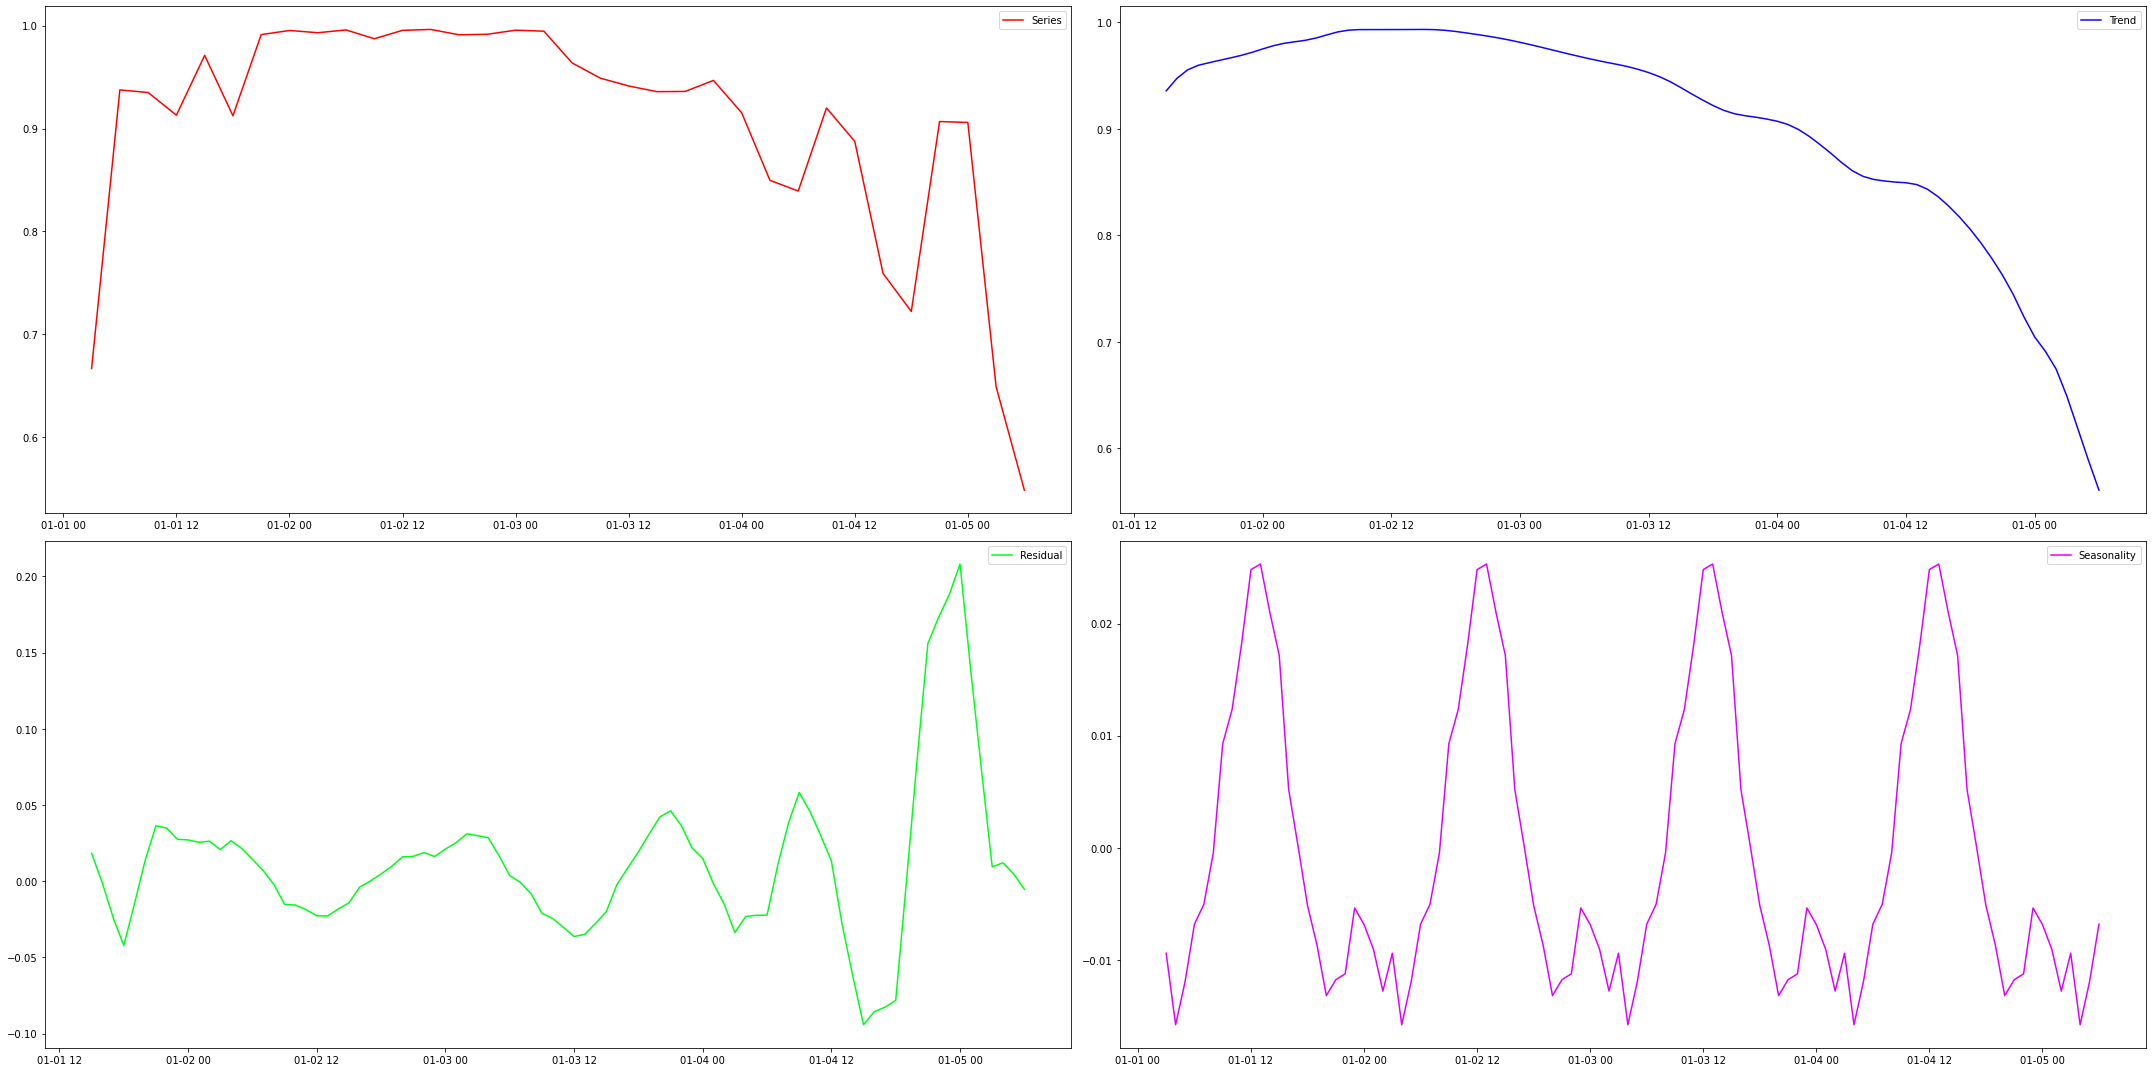

In [18]:
series=df[target_column]
decomposition=seasonal_decompose(series, model='additive')
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
thresh=100
plt.figure(figsize=(30,15))
plt.subplot(221)
plt.plot(series.iloc[:100],color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend.iloc[:100],color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual.iloc[:100],color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal.iloc[:100],color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Autocorrelation

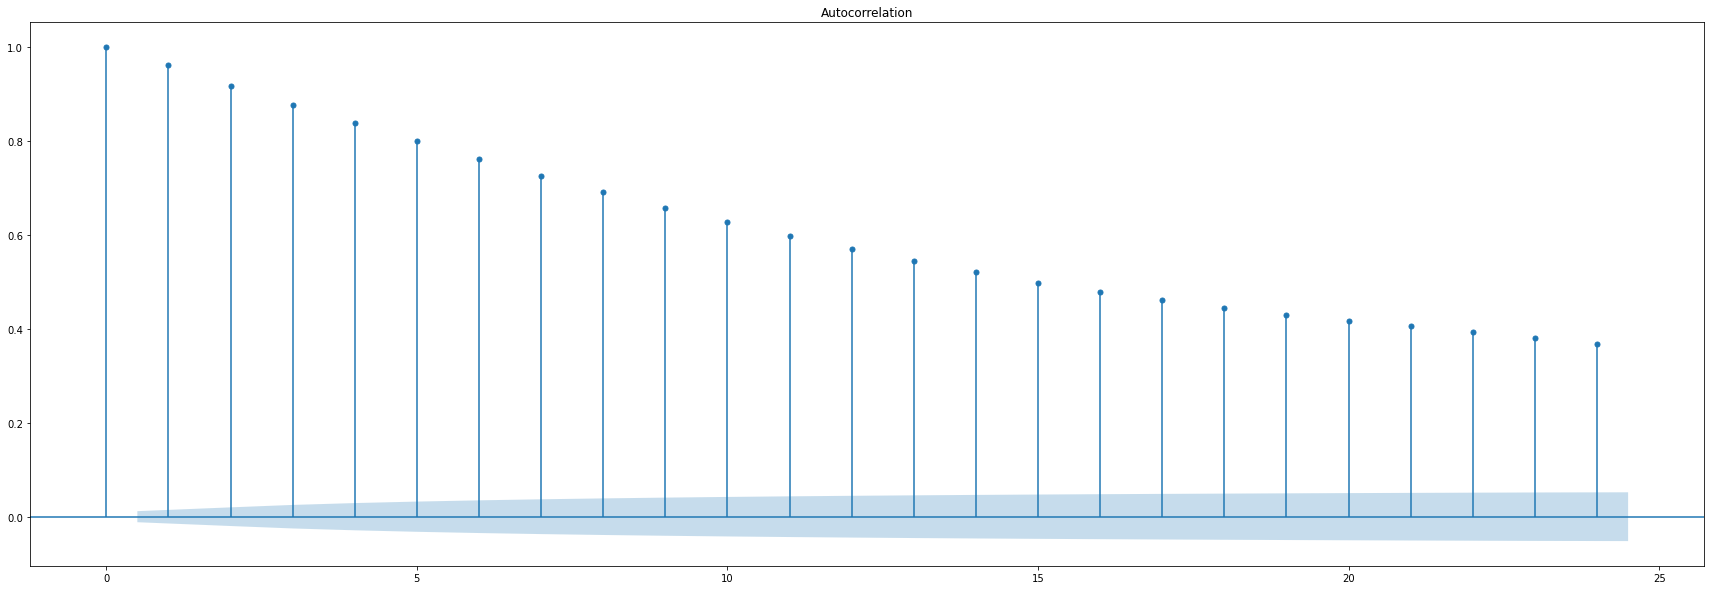

In [19]:
series=df[target_column]
fig, ax = plt.subplots(figsize=(30, 10))
fig=plot_acf(series,lags=24,ax=ax)
plt.show()

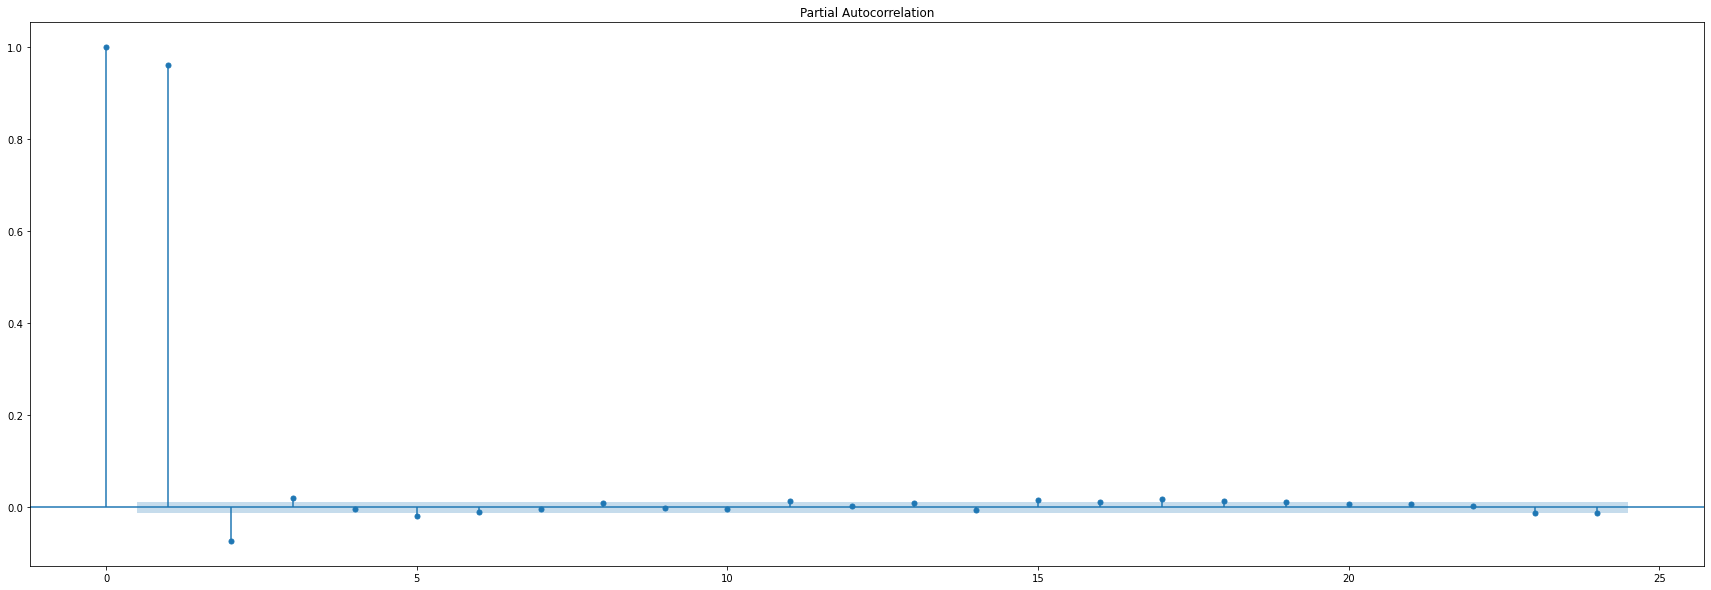

In [20]:
fig, ax = plt.subplots(figsize=(30, 10))
fig=plot_pacf(series,lags=24,ax=ax)
plt.show()

## Compute lagged values

In [21]:
for col, window in dicLagged.items():
    df[target_column+col]=df[target_column].rolling(abs(window)).mean().shift(window)


/Users/mac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df.head()

,POWER,U10,V10,U100,V100,WS10,WS100,WS,FillInterp,MISSING,FillMean,FillMedian,FillRollingMean,FillRollingMedian,FillInterp_X12,FillInterp_X24,FillInterp_Y12,FillInterp_Y24
TIMESTAMP,,,,,,,,,,,,,,,,,,
2015-01-01 03:00:00,0.666693,5.99531,4.89334,9.52143,6.99094,7.738767,11.812319,10.454468,0.666693,NaN,0.666693,0.666693,0.666693,0.666693,NaN,NaN,0.913765,0.942477
2015-01-01 04:00:00,NaN,6.90809,4.79099,10.63280,6.75417,8.406860,12.596636,11.200044,0.756962,0.666693,0.517775,0.538978,0.666693,0.666693,NaN,NaN,0.929978,0.952354
2015-01-01 05:00:00,NaN,6.95268,4.83204,10.70080,6.74193,8.466898,12.647559,11.254005,0.847231,0.666693,0.517775,0.538978,0.666693,0.666693,NaN,NaN,0.937037,0.958508
2015-01-01 06:00:00,0.937501,6.17865,5.70277,9.73491,8.09731,8.408169,12.662342,11.244284,0.937501,NaN,0.937501,0.937501,0.937501,0.937501,NaN,NaN,0.934944,0.960939
2015-01-01 07:00:00,NaN,7.63436,4.76415,11.73130,6.60519,8.998921,13.462984,11.974963,0.936668,0.802097,0.517775,0.538978,0.802097,0.802097,NaN,NaN,0.935111,0.963285


In [23]:
#diff_series=(series-series.shift(1)).dropna()
y = series.values
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Lags used: %f' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.501724
p-value: 0.000000
Lags used: 24.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Fitting model

In [24]:
X=df["WS"].values.reshape(-1,1)
lowest_error=1
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mdl=SARIMAX(y_train, exog=X_train, order=(1,0,0), seasonal_order=(0,0,0,24),
                enforce_stationarity=True, enforce_invertibility=False).fit()
    y_pred=mdl.predict(start =test_index[0], end=test_index[-1],exog=X_test)
    mse=mean_squared_error(y_test,y_pred)
    print("MSE:",mse)
    if lowest_error>mse:
        lowest_error=mse
        best_mdl=mdl
    
    


MSE: 0.13451450691550407
MSE: 0.1172829148883134
MSE: 0.13294546954078718


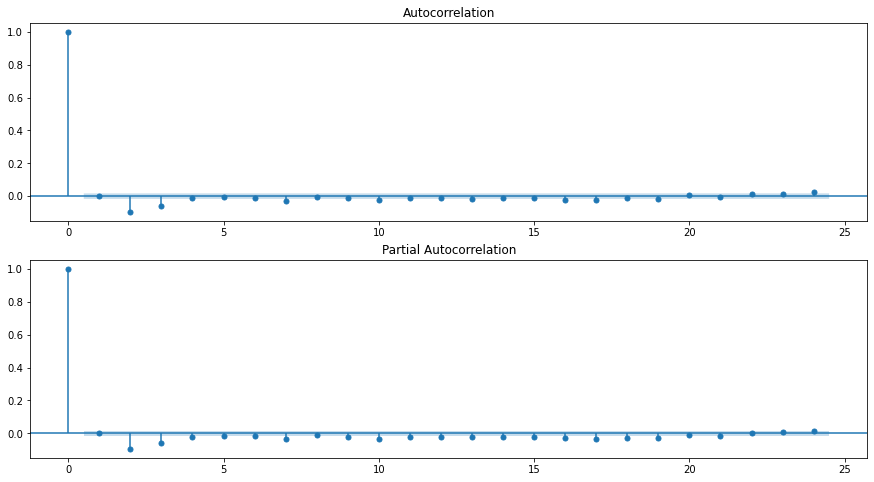

In [25]:
res = best_mdl.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(res, lags=24, ax=ax[0])
fig = plot_pacf(res, lags=24, ax=ax[1])
plt.show()

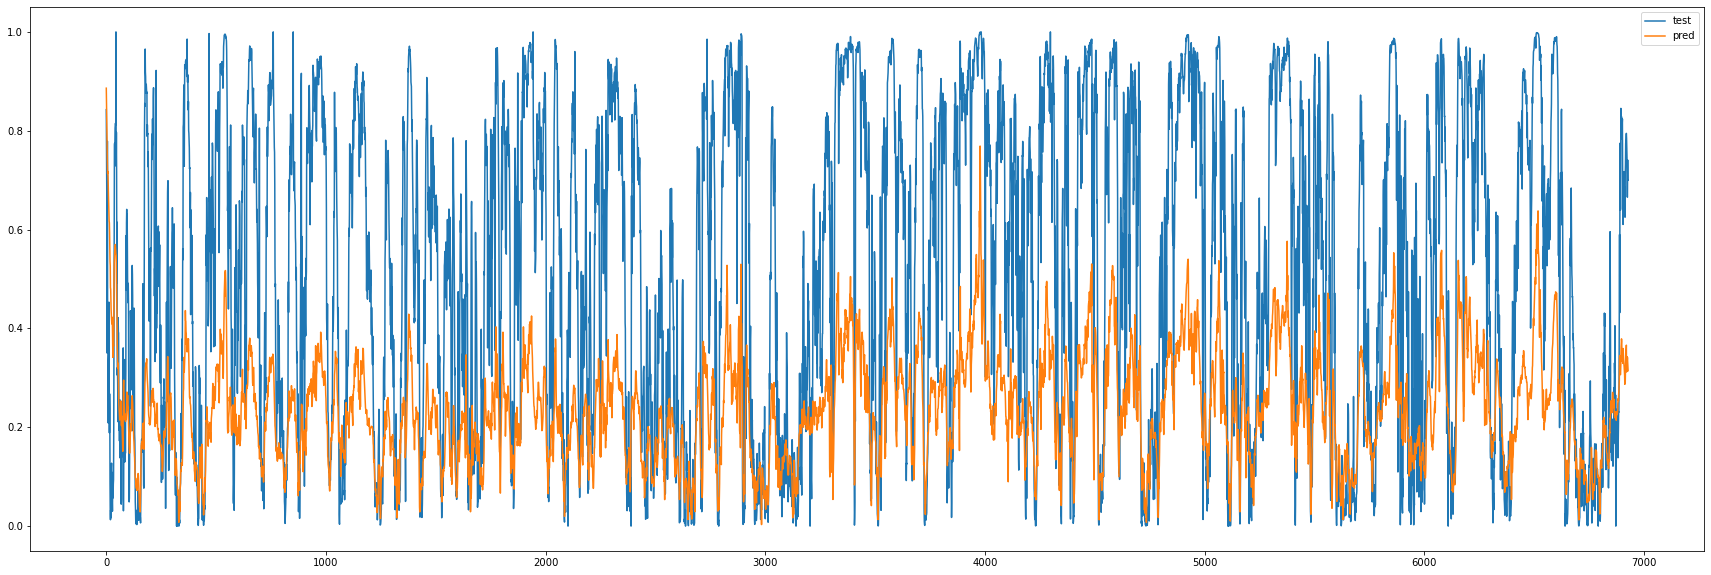

In [26]:
pd.DataFrame({'test':y_test,'pred':y_pred}).plot(figsize=(30,10))
plt.show()

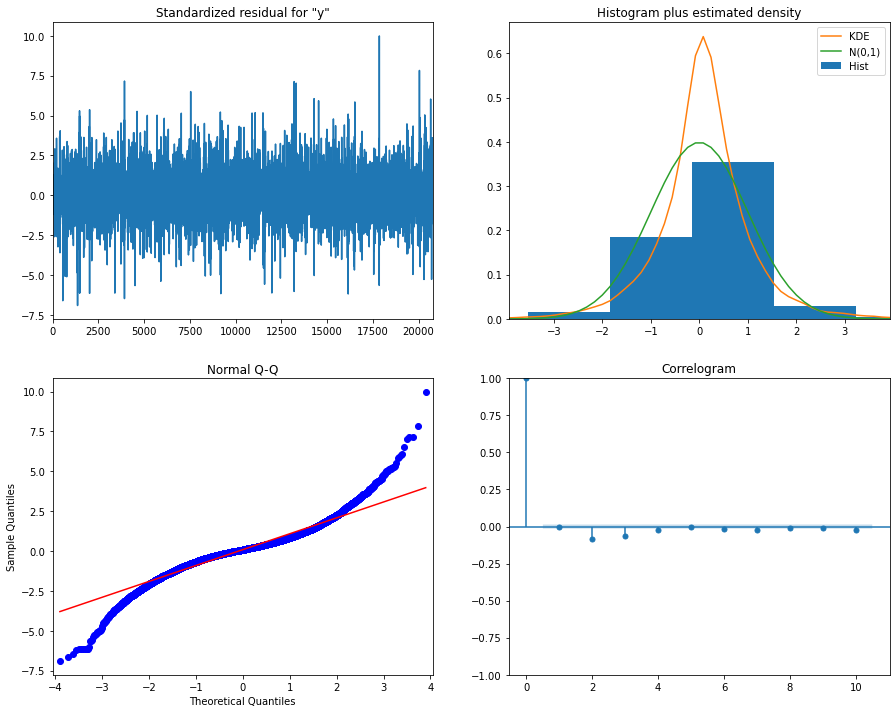

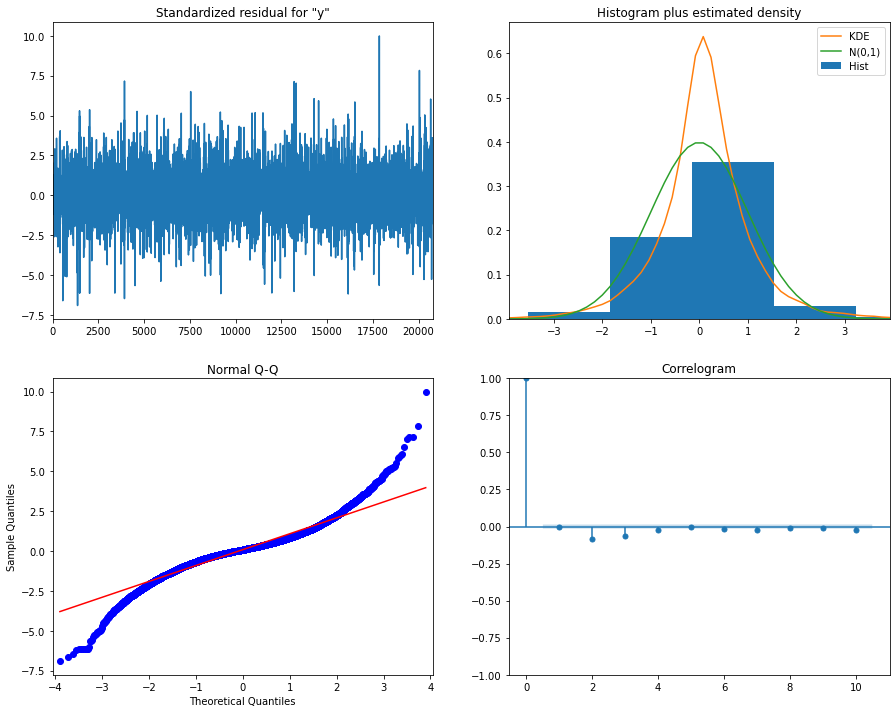

In [27]:
mdl.plot_diagnostics(figsize=(15, 12))

**The QQ plots will show us if our series is normally distributed by plotting its distribution against normally distributed series**
* It seems that there is quite a bit of deviation, which implies skewness in our data (also shown in the histogram plot)

### Modeling with Facebook Prophet

In [28]:
from fbprophet import Prophet

In [29]:
#data=series.reset_index()
#data.rename(columns={"TIMESTAMP":"ds",target_column:"y"},inplace=True)

In [30]:
data=series.reset_index()
data.rename(columns={"TIMESTAMP":"ds",target_column:"y"},inplace=True)

In [31]:
data.shape

(27718, 2)

In [32]:
#model=Prophet(interval_width=0.8,seasonality_mode="additive")
#model.add_seasonality(name='dailyy', period=24, fourier_order=3)
model=Prophet()

In [33]:
#model.fit(data)

In [34]:
data

,ds,y
0,2015-01-01 03:00:00,0.666693
1,2015-01-01 04:00:00,0.756962
2,2015-01-01 05:00:00,0.847231
3,2015-01-01 06:00:00,0.937501
4,2015-01-01 07:00:00,0.936668
...,...,...
27713,2018-02-28 20:00:00,0.666377
27714,2018-02-28 21:00:00,0.665494
27715,2018-02-28 22:00:00,0.740842
27716,2018-02-28 23:00:00,0.699803
